# GLM

In [67]:
# ---------- CONFIG ----------
monkey = 'monkeyN' # monkeyF
out_size = (64, 64)  # RF grid resolution: 64x64 "sensors" (stimulus pixels); 128 is already crashing my system
n_subset = 5000 # random subset of >22k images in train set
shuffle_mapping = False # Shuffle true mapping of MUA - image. acts as sanity check.
reg = None #l1, l2, elastic

In [76]:
# ---------- IMPORTS ----------
import os
import numpy as np
from PIL import Image
import h5py
import matplotlib.pyplot as plt
from os.path import join
# ---------- DIR ----------
wd = r"E:\radboud\Masters Thesis"
# image-side tree
image_side_dir = join(wd, 'source data', 'image data')
things_dir = join(image_side_dir, 'THINGS')
object_images_dir = os.path.join(things_dir,"images_THINGS", "object_images")
# ephys side tree
ephys_side_dir = join(wd, 'source data', 'neural data')
tvsd_dir = join(ephys_side_dir, 'TVSD')
log_path = join(tvsd_dir, monkey, '_logs')
image_MUA_mapping = join(log_path, 'things_imgs.mat') # mapping
normMUA_path = join(tvsd_dir, monkey, 'THINGS_normMUA.mat')
# derivatives tree
derivatives_ephys_dir = join(wd, 'derivatives', 'neural data', 'TVSD')
derivatives_rf_dir = join(derivatives_ephys_dir, monkey, 'ReceptiveFields')
# ana tree
ana_dir = join(wd, 'analysis', 'TVSD')
ana_monkey_dir = join(ana_dir, monkey)
# 

In [7]:
# ---------- image side helpers ----------
def prepare_THINGS_objects(image_MUA_mapping, verbose = False):
    with h5py.File(image_MUA_mapping, "r") as f:
        train_group = f["train_imgs"]
        test_group  = f["test_imgs"]

        class_refs       = train_group["class"][()]        # (22248,)
        local_path_refs  = train_group["local_path"][()]   # (22248,)
        things_path_refs = train_group["things_path"][()]  # (22248,)

        print("class_refs shape:", class_refs.shape, "dtype:", class_refs.dtype)
        print("local_path_refs shape:", local_path_refs.shape, "dtype:", local_path_refs.dtype)
        print("things_path_refs shape:", things_path_refs.shape, "dtype:", things_path_refs.dtype)

        def unwrap_ref(ref):
            """
            Unwrap a reference that may be:
            - an h5py.Reference
            - a 0-d or 1-d numpy array containing a Reference
            and return a true h5py.Reference.
            """
            # Direct reference
            if isinstance(ref, h5py.Reference):
                return ref

            # 0-d / 1-d numpy array wrapping the reference
            arr = np.array(ref)
            if arr.dtype == object and arr.size > 0:
                inner = arr.ravel()[0]
                if isinstance(inner, h5py.Reference):
                    return inner
                # if it's still an array, recurse once
                if isinstance(inner, np.ndarray):
                    return unwrap_ref(inner)

            # Fallback: just try to treat ref as-is (will error if wrong)
            return ref

        def dset_to_str(dset):
            """
            Convert a dataset (often MATLAB char array) to a Python string.
            Handles:
            - bytes
            - numpy arrays of 'S'/'U'
            - numpy arrays of uint16/int16/int32 char codes
            """
            data = dset[()]  # grab contents

            # plain python types
            if isinstance(data, bytes):
                return data.decode("utf-8")
            if isinstance(data, str):
                return data

            arr = np.array(data)

            # string-like arrays
            if arr.dtype.kind in {"S", "U"}:
                flat = arr.ravel()
                parts = []
                for x in flat:
                    if isinstance(x, (bytes, bytearray)):
                        parts.append(x.decode("utf-8"))
                    else:
                        parts.append(str(x))
                return "".join(parts)

            # numeric char codes (MATLAB-style)
            if arr.dtype in (np.uint16, np.int16, np.int32, np.int64):
                chars = [chr(int(c)) for c in arr.ravel() if int(c) != 0]
                return "".join(chars)

            # last resort
            return str(arr)

        def refs_to_str_array(refs):
            strings = []
            for ref in refs:
                href = unwrap_ref(ref)
                dset = f[href]           # <--- this is where we previously passed an ndarray
                s = dset_to_str(dset)
                strings.append(s)
            return np.array(strings, dtype=object)

        train_class       = refs_to_str_array(class_refs)
        train_local_path  = refs_to_str_array(local_path_refs)
        train_things_path = refs_to_str_array(things_path_refs)
    if verbose:
        print('structure overview for index 0:')
        print("train_class[0]:      ", train_class[0])
        print("train_local_path[0]: ", train_local_path[0])
        print("train_things_path[0]:", train_things_path[0])
        print("n_train:", len(train_things_path))

    return train_class, train_local_path, train_things_path 

from PIL import Image
def load_image_downsample_gray(rel_path, root, size, verbose=False):
    """
    Load an image given a relative path, convert to grayscale, resize, and
    normalize to [0, 1].

    Args:
        rel_path: relative path to image (e.g. "aardvark/aardvark_01b.jpg")
        root: root directory where images live
        size: (H, W) tuple for resizing
        verbose: if True, print debug info

    Returns:
        arr: np.ndarray of shape (H, W), float32 in [0, 1]
    """
    img_path = os.path.join(root, rel_path)

    if verbose:
        print(f"[load_image] Loading: {img_path}")

    img = Image.open(img_path).convert("L")  # grayscale
    orig_w, orig_h = img.size

    if verbose:
        print(f"[load_image] Original size: {orig_w}x{orig_h} -> resizing to {size[0]}x{size[1]}")

    img = img.resize(size, Image.BILINEAR)
    arr = np.array(img, dtype=np.float32)
    arr /= 255.0  # scale to [0,1]

    if verbose:
        print(f"[load_image] After resize: shape={arr.shape}, "
              f"min={arr.min():.3f}, max={arr.max():.3f}")

    return arr

In [15]:
# ---------- RF HELPERS ----------
def build_stimulus_and_response(
    image_paths,
    responses,
    root,
    size,
    idxs=None,
    verbose=True,
):
    """
    Build stimulus matrix X and response matrix R.

    Args:
        image_paths: array-like of length N_all with relative image paths.
        responses: np.ndarray of shape (N_all, E) with MUA responses.
        root: root directory for images.
        size: (H, W) for downsampled grayscale images.
        idxs: optional indices of images to use; if None, use all.
        verbose: if True, print debug info.

    Returns:
        X: np.ndarray of shape (N, D)  (N images, D pixels)
        R: np.ndarray of shape (N, E)  (N images, E electrodes)
        img_shape: tuple (H, W)
    """
    image_paths = np.asarray(image_paths)
    N_all = len(image_paths)

    if idxs is None:
        idxs = np.arange(N_all)
        if verbose:
            print(f"[build_SR] Using ALL {N_all} training images.")
    else:
        idxs = np.asarray(idxs)
        if verbose:
            print(f"[build_SR] Using subset of {len(idxs)} images out of {N_all} total.")

    N = len(idxs)
    E = responses.shape[1]

    # Load first image once to infer shape
    if verbose:
        print(f"[build_SR] Loading first example image at index {idxs[0]} for shape inference.")
    example_img = load_image_downsample_gray(image_paths[idxs[0]], root=root, size=size, verbose=verbose)
    H, W = example_img.shape
    D = H * W

    if verbose:
        print(f"[build_SR] Image shape: {H}x{W} -> D={D} pixels per image.")
        print(f"[build_SR] Number of electrodes E={E}")
        print(f"[build_SR] Allocating X with shape (N={N}, D={D}), R with shape (N={N}, E={E})")

    X = np.zeros((N, D), dtype=np.float32)
    R = np.zeros((N, E), dtype=np.float32)

    # Fill first row with example_img so we don't reload it
    X[0, :] = example_img.flatten()
    R[0, :] = responses[idxs[0], :]

    # Loop over remaining indices
    for k, i in enumerate(idxs[1:], start=1):
        if verbose and (k % max(1, N // 10) == 0):
            print(f"[build_SR] Processing image {k+1}/{N} (train index {i})")

        arr = load_image_downsample_gray(image_paths[i], root=root, size=size, verbose=False)
        X[k, :] = arr.flatten()
        R[k, :] = responses[i, :]

    if verbose:
        print(f"[build_SR] Done. X shape: {X.shape}, R shape: {R.shape}")
        print(f"[build_SR] X stats: mean={X.mean():.4f}, std={X.std():.4f}, "
              f"min={X.min():.4f}, max={X.max():.4f}")
        print(f"[build_SR] R stats: mean={R.mean():.4f}, std={R.std():.4f}, "
              f"min={R.min():.4f}, max={R.max():.4f}")

    return X, R, H, W





In [57]:
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import numpy as np
import os
import math
from matplotlib.patches import Rectangle
def plot_rf_grid(
        rf_per_array, array2area,
        monkey,basename = None,
        shuffle_suffix="true_order", vlim=(-0.5, 0.5),
        save_dir=None, 
        dpi=300
    ):
    """
    Dynamically plots RFs for a variable number of arrays.

    rf_per_array: np.ndarray, shape (N_arrays, H, W)
        RFs per array (each corresponding to 64 electrodes).
    array2area: dict
        Mapping from 1-based array number -> area label.
    """
    n_arrays, H, W = rf_per_array.shape
    n_cols = min(4, n_arrays)  # 4 max per row
    n_rows = math.ceil(n_arrays / n_cols)

    fig = plt.figure(figsize=(3.2 * n_cols, 3.2 * n_rows))
    suptitle = f'{monkey} – GLM-based RFs per array ({shuffle_suffix})'
    fig.suptitle(suptitle, fontsize=18)

    gs = GridSpec(
        n_rows,
        n_cols + 1,  # extra column for colorbar
        width_ratios=[1] * n_cols + [0.05],
        wspace=0.4,
        hspace=0.5
    )

    # color limits
    if vlim is None:
        vmax = np.max(np.abs(rf_per_array))
        vmin = -vmax
    else:
        vmin, vmax = vlim

    
    for idx in range(n_arrays):
        r = idx // n_cols
        c = idx % n_cols
        ax = fig.add_subplot(gs[r, c])

        from matplotlib.patches import Rectangle

        rf = rf_per_array[idx]
        im = ax.imshow(rf, cmap="bwr", vmin=vmin, vmax=vmax)
        ax.axis("off")

        # Add a black rectangle that exactly bounds the image
        rect = Rectangle(
            xy=(-0.5, -0.5),  # top-left corner (matches imshow default pixel centers)
            width=W, height=H,
            linewidth=1.5, edgecolor='black', facecolor='none'
        )
        ax.add_patch(rect)


        array_num = idx + 1  # 1-based
        area = array2area.get(array_num, "unknown")
        ax.set_title(f"Array {array_num} – {area}", fontsize=11, pad=10)

    # colorbar
    cax = fig.add_subplot(gs[:, -1])
    cbar = fig.colorbar(im, cax=cax)
    cbar.set_label("corr(pixel, MUA)")

    plt.tight_layout(rect=[0, 0, 0.96, 0.95])

    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)
        png_path = os.path.join(save_dir, f"{basename}.png")
        pdf_path = os.path.join(save_dir, f"{basename}.pdf")

        fig.savefig(png_path, dpi=dpi, bbox_inches="tight")
        fig.savefig(pdf_path, dpi=dpi, bbox_inches="tight")
        print(f"[plot_rf_grid_dynamic] Saved PNG to: {png_path}")
        print(f"[plot_rf_grid_dynamic] Saved PDF to: {pdf_path}")

    plt.show()


In [10]:
# IMG 
train_class, train_local_path, train_things_path = prepare_THINGS_objects(image_MUA_mapping, verbose=False)
## class_refs shape: (22248, 1) dtype: object
## local_path_refs shape: (22248, 1) dtype: object
## things_path_refs shape: (22248, 1) dtype: object
## MUA
with h5py.File(normMUA_path, "r") as f:
    SNR           = np.array(f["SNR"])             # (4, 1024)
    SNR_max       = np.array(f["SNR_max"])         # (1024, 1)
    lats          = np.array(f["lats"])            # (4, 1024)
    oracle        = np.array(f["oracle"])          # (1024, 1)
    reliab        = np.array(f["reliab"])          # (435, 1024)
    tb            = np.array(f["tb"])              # (300, 1)
    test_MUA      = np.array(f["test_MUA"])        # (100, 1024)
    test_MUA_reps = np.array(f["test_MUA_reps"])   # (30, 100, 1024)
    train_MUA     = np.array(f["train_MUA"])       # (22248, 1024)

class_refs shape: (22248, 1) dtype: object
local_path_refs shape: (22248, 1) dtype: object
things_path_refs shape: (22248, 1) dtype: object


In [69]:
# PREPARE and ESTIMATE
# specify  images to use for RF estimation
n_total = len(train_things_path)
print(f"[MAIN] Total available training images: {n_total}")

# For speed, potentially use a random subset, REF to n_subset
idxs = np.random.choice(n_total, size=min(n_subset, n_total), replace=False)
print(f"[MAIN] Using {len(idxs)} images for building X.")

# build X (stimuli) and R (responses)
X, R, H, W = build_stimulus_and_response(
    image_paths=train_things_path,
    responses=train_MUA,
    root=object_images_dir,
    size=out_size,
    idxs=idxs,   # or some subset
    verbose=False,
)
print(f"[MAIN] X shape: {X.shape}, R shape: {R.shape}, img_shape: {H, W}")
# --- Monkey N: which Utah array is in which area ---
# WARNING: order is a placeholder – adjust once you know the true array order from TVSD metadata.

if shuffle_mapping:
        N, D = X.shape
        E = R.shape[1]
        # get a random permutation of the N trials
        perm = np.random.permutation(N)        # shape: (N,)
        # shuffle responses relative to stimuli
        R = R[perm, :]    
        order = 'shuffled'
else:            
    order = 'ordered'
    
saving=True
if saving:
    save_dir = join(derivatives_rf_dir, 'linear')
    os.makedirs(save_dir, exist_ok=True)

    data_fname = f"{monkey}_X_R_imgshape{len(idxs)}_{order}.npz"
    save_path = os.path.join(save_dir, data_fname)

    np.savez_compressed(save_path, X=X, R=R, H=H, W=W)
    print(f"[SAVE] Saved stimulus-response data to: {save_path}")



[MAIN] Total available training images: 22248
[MAIN] Using 5000 images for building X.
[MAIN] X shape: (5000, 4096), R shape: (5000, 1024), img_shape: (64, 64)
[SAVE] Saved stimulus-response data to: E:\radboud\Masters Thesis\derivatives\neural data\monkeyN\ReceptiveFields\linear\monkeyN_X_R_imgshape5000_ordered.npz


In [ ]:
## LOADING
# Construct load path
loading=False
if loading:
    if shuffle_mapping:
        order = 'shuffled'
    else:
        order = 'ordered'
    len_idxs = 2000 # how many images to include
    load_path = join(derivatives_rf_dir, 'linear', f"{monkey}_X_R_imgshape{len_idxs}_{order}.npz")

    # Load .npz file
    loaded = np.load(load_path)
    X = loaded["X"]
    R = loaded["R"]
    H = int(loaded["H"])
    W = int(loaded["W"])

    print(f"[LOAD] Loaded X shape: {X.shape}, R shape: {R.shape}, img shape: {(H, W)}")

| `l1_ratio` Value | Effect                 | Behavior                                        |
| ---------------- | ---------------------- | ----------------------------------------------- |
| `0.0`            | All Ridge (L2)         | Shrinks coefficients smoothly, rarely to zero   |
| `1.0`            | All Lasso (L1)         | Promotes sparsity, may set some weights to zero |
| `0.5`            | Even mix of L1 and L2  | Balanced: some sparsity and shrinkage           |
| `0.1`, `0.9`     | Mostly L2 or mostly L1 | Emphasizes one over the other                   |


In [ ]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
# ---------- FIT GLM ----------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
N, D = X_scaled.shape
E = R.shape[1]
#E = 256
assert E % 64 == 0

RFs = np.zeros((E, H * W))
for i in range(E):
    if i%5 == 0:
        print(i)
    y = R[:, i]
    #model = Ridge(alpha=0.10)

    # ElasticNet for a balance between sparsity and smoothness
    # l1 ~
    model = ElasticNet(alpha=0.2, l1_ratio=0.7)
    model.fit(X_scaled, y)
    RFs[i] = model.coef_

0
5
10
15
20
25
30
35
40
45
50
55


[MAIN] Saved rf_per_array to: E:\radboud\Masters Thesis\analysis\TVSD\monkeyN\Exploration\ReceptiveFields\GLM\monkeyN_GLM_RFs_true_order_rf_per_array.npy


C:\Users\Radovan\AppData\Local\Temp\ipykernel_26372\3536792068.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.96, 0.95])


[plot_rf_grid_dynamic] Saved PNG to: E:\radboud\Masters Thesis\analysis\TVSD\monkeyN\Exploration\ReceptiveFields\GLM\monkeyN_GLM_RFs_true_order.png
[plot_rf_grid_dynamic] Saved PDF to: E:\radboud\Masters Thesis\analysis\TVSD\monkeyN\Exploration\ReceptiveFields\GLM\monkeyN_GLM_RFs_true_order.pdf


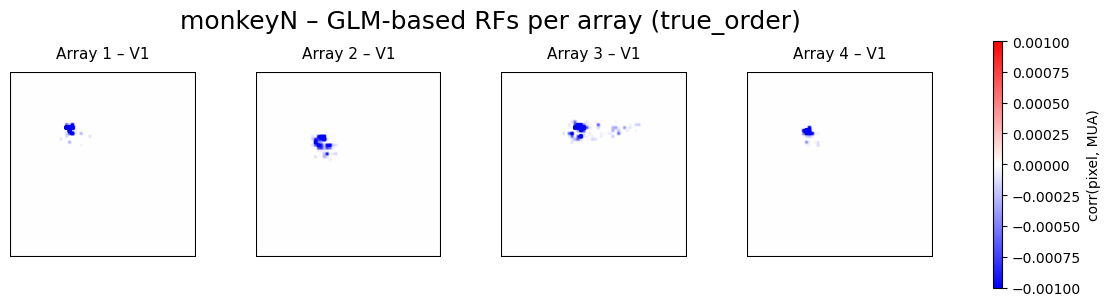

In [ ]:
# Plotting
# array 
if monkey == 'monkeyN':
    # Nilson
    array2area = {
        1:  'V1', 2: 'V1', 3:  'V1', 4:  'V1',
        5:  'V1',  7:  'V1', 8:  'V1',
        9:  'V4', 10: 'V4', 11: 'V4', 12: 'V4',
        13: 'IT', 14: 'IT', 15: 'IT', 16: 'IT',
        6:  'cut'
    }
elif monkey == 'monkeyF':
    # Finch
    array2area = {
        1:  'V1', 2: 'V1', 3:  'V1', 4:  'V1',
        5:  'V1', 6:  'V1', 7:  'V1', 8:  'V1',
        9:  'V4', 10: 'V4', 11: 'V4', 12: 'V4',
        13: 'IT', 14: 'IT', 15: 'IT', 16: 'IT',
    }
# RFs: (1024, , W')
RFs_reshaped = RFs.reshape(E, 64, 64)  # shape (1024, 64, 64)
rf_per_array = RFs_reshaped.reshape(int(E/64), 64, 64, 64).mean(axis=1)  # shape (16, 64, 64, 64)
                                                                           #^ nr. of electrodes under investigation

#assert E == 1024, "Expected 1024 electrodes for 16 Utah arrays"
# reshape to (16 arrays, 64 electrodes per array, H, W) and average over electrodes

# determine shuffling
if shuffle_mapping:
    shuffle_suffix = 'shuffled_order'
else:
    shuffle_suffix = 'true_order'


save_dir = join(ana_monkey_dir, 'Exploration', 'ReceptiveFields', 'GLM')
os.makedirs(save_dir, exist_ok=True)
basename = f'{monkey}_GLM_RFs_{shuffle_suffix}'
rf_save_path = os.path.join(save_dir, f"{basename}_rf_per_array.npy")
np.save(rf_save_path, rf_per_array)
print(f"[MAIN] Saved rf_per_array to: {rf_save_path}")

# plot 16 averaged RFs (Utah arrays)
#plot_rf_grid_monkeyN(
#        rf_per_array, array2area, shuffle_suffix=shuffle_suffix,
#        vlim=(-0.3, 0.3), basename=basename, save_dir=save_dir)

plot_rf_grid(
    rf_per_array, array2area, vlim=(-1e-2, 1e-2),
    monkey="monkeyN", shuffle_suffix=shuffle_suffix,
    save_dir=save_dir, basename=basename
)
